# Dependency of probe profiles on defocus #

## A NOTE BEFORE STARTING ##

Since the ``embeam`` git repository tracks this notebook under its original
basename ``probe_profile_vs_defocus.ipynb``, we recommend that you copy the
original notebook and rename it to any other basename that is not one of the
original basenames that appear in the ``<root>/examples`` directory before
executing any of the notebook cells below, where ``<root>`` is the root of the
``embeam`` repository. This way you can explore the notebook by executing and
modifying cells without changing the original notebook, which is being tracked
by git.

## Import necessary modules ##

In [1]:
# For special mathematical constants.
import numpy as np

# For interpolating data.
import scipy.interpolate

# For setting various visualization parameters.
import matplotlib.pyplot as plt

# For creating hyperspy signals.
import hyperspy.signals

# For creating hyperspy signals.
import hyperspy.axes

# For additional tools applicable to ``hyperspy`` signals. Users may receive a
# warning message about ``pyopencl`` upon importing ``empix``. This message can
# be safely ignored.
import empix



# The library that is the subject of this demonstration.
import embeam

## Introduction ##

In this notebook, we demonstrate how one can use ``embeam`` to study the
dependency of probe profiles on the target operating defocus $\Delta f$ for
probes subject to spherical aberrations, as well probes subject to both
spherical and chromatic aberrations. In particular, we estimate the following as
a function of the target operating defocus: the information resolution
$R_{\text{inf}}$ (see
[here](https://mrfitzpa.github.io/embeam/_autosummary/embeam.stem.probe.resolution.information.html)
for a definition); the 20 percent to 80 percent rise-distance resolution
$R_{\text{20-80}}$ (see
[here](https://mrfitzpa.github.io/embeam/_autosummary/embeam.stem.probe.resolution.rise_distance.html)
for a generic definition of the rise-distance resolution); the 30 percent to 70
percent rise-distance resolution $R_{\text{30-70}}$ rise-distance resolution;
the fractional intensity profile
$p_{\text{probe}}\left(\left.X=x\right|Y=0\right)$; the integrated current
profile,
$2\pi\int_{0}^{x}dx^{\prime}\,p_{\text{probe}}\left(\left.X=x^{\prime}\right|Y=0\right)$;
the radius at which the integrated current equals 0.80, $r_{xy; 80}$; and the
radius at which the integrated current equals 0.90, $r_{xy; 90}$. The resolution
metrics are compared to the effective probe radii calculated from two different
cone models: 1. $\left|\Delta f-\Delta
f_{\text{B\&L}}^{\text{opt}}\right|\alpha$, where $\alpha$ is the probe
convergence semiangle and $\Delta
f_{\text{B\&L}}^{\text{opt}}=-\frac{1}{2}C_s\alpha^2$, with $C_s$ being the
strength of the spherical aberrations; and 2. $\left|\Delta f-\Delta
f_{\mathrm{30-70}}^{\mathrm{opt}}\right|\alpha$, where $\Delta
f_{\mathrm{30-70}}^{\mathrm{opt}}=\min_{\Delta
f}\left(R_{\text{30-70}}\right)$. The first cone model was proposed by Black and
Linfoot (see
[here](https://royalsocietypublishing.org/doi/10.1098/rspa.1957.0059) for their
paper introducing the model).

Note that the code in this notebook exploits the fact that we are studying
probes that are **azimuthally symmetric**.

In order to execute the cells in this notebook as intended, a set of Python
libraries need to be installed in the Python environment within which the cells
of the notebook are to be executed. For this particular notebook, users need to
install:

    embeam
    jupyter

Users can install these libraries either via `pip`:

    pip install embeam[examples]

or `conda`:

    conda install -y embeam jupyter -c conda-forge

You can find the documentation for the emicroml library
[here](https://mrfitzpa.github.io/embeam/_autosummary/embeam.html). It is
recommended that you consult the documentation of this library as you explore
the notebook. Moreover, users should execute the cells in the order that they
appear, i.e. from top to bottom, as some cells reference variables that are set
in other cells above them. **Users should make sure to navigate the
documentation for the version of emicroml that they are currently using.**

## Setting fixed probe model parameters ##

The gun model parameters common to all probes. See
[here](https://mrfitzpa.github.io/embeam/_autosummary/embeam.gun.ModelParams.html)
for a description of the gun model parameters.

In [2]:
mean_beam_energy = 20  # In units of keVs.
intrinsic_energy_spread = 0.6e-3  # In units of keVs.
accel_voltage_spread = 0  # In units of kVs.

The lens model parameters common to all probes. See
[here](https://mrfitzpa.github.io/embeam/_autosummary/embeam.lens.ModelParams.html)
for a description of the lens model parameters.

In [3]:
C_s = 8  # Strength of spherical aberrations, in units of mm.

mean_current = 50  # In units of pA.
std_dev_current = 0  # In units of pA.

The strength of the chromatic aberrations to which all incoherent probes
subject.

In [4]:
C_c = 8  # In units of mm.

Remaining miscellaneous fixed probe model parameters common to all probes. See
[here](https://mrfitzpa.github.io/embeam/_autosummary/embeam.stem.probe.ModelParams.html)
for a description of these model parameters.

In [5]:
convergence_semiangle = 4.84  # In units of mrads.
defocal_offset_supersampling = 9  # Dimensionless.

## Choose target operating defocii of interest ##

In [6]:
min_target_operating_defocus = -12000  # In units of Å.
max_target_operating_defocus = 8000  # In units of Å.
num_target_operating_defocii = 50

# In units of Å.
target_operating_defocii = np.linspace(min_target_operating_defocus, 
                                       max_target_operating_defocus, 
                                       num=num_target_operating_defocii)

## Setting $r$-space discretization parameters and periodic boundary conditions ##

It is computationally cheaper to approximate the exact $r$-space fractional
intensity, $p_{\text{probe}}\left(\left.X=x\right|Y=y\right)$, of a given probe
of interest by a different function,
$\tilde{p}_{\text{probe}}\left(\left.X=x\right|Y=y\right)$, that is subject to
periodic boundary conditions, which in the limit of an infinitely large square
unit cell equals the exact $r$-space fractional intensity. In estimating the
various quantities that characterize the probe profile, we sample
$\tilde{p}_{\text{probe}}\left(\left.X=x\right|Y=y\right)$ at a finite set of
points that lie on a rectangular grid in $r$-space. The finer the grid, the more
accurate the estimations of said quantities.

In the cell below, we set the $r$-space discretization parameters and periodic
boundary conditions.

In [7]:
# The dimensions of the unit cell in units of Å.
L_x = 400  # x-dimension.
L_y = 400  # y-dimension.

# The dimensions of the unit cell in units of pixels.
N_x = 1024  # x-dimension.
N_y = 1024  # y-dimension.

## Setting electron detector parameters ##

In the cell below, we set two parameters that can be used to determine the
dimensions of a reconstruction patch in a Ptychography experiment. These
parameters are the number of pixels across the electron detector, $n_x$, and the
reconstruction pixel size, $\Delta \tilde{x}$. The width of the reconstruction
patch is then given by $\Delta \tilde{X} = n_x \Delta \tilde{x}$. In
Ptychography, you want to make sure that most if not all of the intensity of the
probe is contained within the dimensions of the reconstruction patch.

In [8]:
num_pixels_across_detector = 512  # Dimensionless.
reconstruction_pixel_size = 0.50  # In units of Å.

## Setting remaining fixed parameters ##

We need to specify the signal to noise ratio in order to estimate the
information resolution of the probes.

In [9]:
signal_to_noise_ratio = 50  # Dimensionless.

## Estimating various quantities characterizing the probe profile for each value of the target operating defocus ##

There are no variables in the cell below that need to be set or modified.

In [10]:
# Construct gun model parameters object to be used to model all probes.
kwargs = {"mean_beam_energy": mean_beam_energy, 
          "intrinsic_energy_spread": intrinsic_energy_spread, 
          "accel_voltage_spread": accel_voltage_spread}
gun_model_params = embeam.gun.ModelParams(**kwargs)



# Electron beam wavelength in units of Å.
wavelength = embeam.wavelength(mean_beam_energy)



# Construct object representing spherical aberration.
m = 4
n = 0
C_4_0_mag = (2*np.pi*(C_s*1e7))/(m*wavelength)
C_4_0_ang = 0
spherical_aberration = embeam.coherent.Aberration(m=4, 
                                                  n=0, 
                                                  C_mag=C_4_0_mag, 
                                                  C_ang=C_4_0_ang)



# The optimum defocus according to Black and Linfoot [G. Black and E.H. Linfoot,
# Proc. R. Soc. (London) A, 239 (1957)], in units of nm.
optimum_df_black_and_linfoot = \
    -0.5 * (C_s*1e6) * (convergence_semiangle/1000)**2



# Initialize arrays storing resolution metrics, all in units of nm.
information_resolutions_for_coherent_probes = \
    np.zeros([num_target_operating_defocii])
information_resolutions_for_incoherent_probes = \
    np.zeros([num_target_operating_defocii])
rise_distance_20_80_resolutions_for_coherent_probes = \
    np.zeros([num_target_operating_defocii])
rise_distance_20_80_resolutions_for_incoherent_probes = \
    np.zeros([num_target_operating_defocii])
rise_distance_30_70_resolutions_for_coherent_probes = \
    np.zeros([num_target_operating_defocii])
rise_distance_30_70_resolutions_for_incoherent_probes = \
    np.zeros([num_target_operating_defocii])



# Radii at which to evaluate probe intensity, and the normalized integrated beam
# current.
num_r_xy_pts = N_x-(N_x//2)
r_xy = (L_x/N_x) * np.arange(0, num_r_xy_pts)



# Initialize arrays storing probe intensity profiles in dimensionless units, and
# normalized integrated beam current profiles in dimensionless units.
intensity_profiles_for_coherent_probes = \
    np.zeros([num_target_operating_defocii, num_r_xy_pts])
intensity_profiles_for_incoherent_probes = \
    np.zeros([num_target_operating_defocii, num_r_xy_pts])
integrated_current_profiles_for_coherent_probes = \
    np.zeros([num_target_operating_defocii, num_r_xy_pts])
integrated_current_profiles_for_incoherent_probes = \
    np.zeros([num_target_operating_defocii, num_r_xy_pts])



# Initialize arrays storing the radii at which the normalized integrated beam 
# currents equal 0.80, in units of nm.
integrated_current_80_percent_contour_for_coherent_probes = \
    np.zeros([num_target_operating_defocii])
integrated_current_80_percent_contour_for_incoherent_probes = \
    np.zeros([num_target_operating_defocii])



# Initialize arrays storing the radii at which the normalized integrated beam 
# currents equal 0.90, in units of nm.
integrated_current_90_percent_contour_for_coherent_probes = \
    np.zeros([num_target_operating_defocii])
integrated_current_90_percent_contour_for_incoherent_probes = \
    np.zeros([num_target_operating_defocii])



for idx, df in enumerate(target_operating_defocii):
    # Construct object representing defocus aberration.
    m = 2
    n = 0
    C_2_0_mag = (2*df*np.pi)/(m*wavelength)
    C_2_0_ang = 0
    defocus_aberration = embeam.coherent.Aberration(m=m, 
                                                    n=n, 
                                                    C_mag=C_2_0_mag, 
                                                    C_ang=C_2_0_ang)


    
    # Group coherent lens aberrations to be used to model all probes.
    coherent_aberrations = (defocus_aberration, spherical_aberration)


    
    # Construct lens model parameters object to be used to model coherent probe.
    kwargs = {"coherent_aberrations": coherent_aberrations, 
              "chromatic_aberration_coef": 0, 
              "mean_current": mean_current, 
              "std_dev_current": std_dev_current}
    lens_model_params_for_coherent_probe = embeam.lens.ModelParams(**kwargs)


    
    # Construct lens model parameters object to be used to model incoherent 
    # probe.
    kwargs["chromatic_aberration_coef"] = C_c
    lens_model_params_for_incoherent_probe = embeam.lens.ModelParams(**kwargs)


    
    # Construct probe model parameters object to be used to model coherent
    # probe.
    kwargs = {"lens_model_params": lens_model_params_for_coherent_probe, 
              "convergence_semiangle": convergence_semiangle,
              "gun_model_params": gun_model_params, 
              "defocal_offset_supersampling": defocal_offset_supersampling}
    coherent_probe_model_params = embeam.stem.probe.ModelParams(**kwargs)


    
    # Construct probe model parameters object to be used to model incoherent
    # probe.
    kwargs = {"lens_model_params": lens_model_params_for_incoherent_probe, 
              "convergence_semiangle": convergence_semiangle,
              "gun_model_params": gun_model_params, 
              "defocal_offset_supersampling": defocal_offset_supersampling}
    incoherent_probe_model_params = embeam.stem.probe.ModelParams(**kwargs)


    
    # Construct discretized periodic r-space fractional intensity that samples a
    # function which approximates the exact r-space fractional intensity of the
    # coherent probe.
    kwargs = \
        {"probe_model_params": coherent_probe_model_params, 
         "pixel_size": (L_x/N_x, L_y/N_y), 
         "viewer_dims_in_pixels": (N_x, N_y)}
    p_probe_coherent = \
        embeam.stem.probe.discretized.periodic.rspace.Intensity(**kwargs)


    
    # Construct discretized periodic r-space fractional intensity that samples a
    # function which approximates the exact r-space fractional intensity of the
    # incoherent probe.
    kwargs = \
        {"probe_model_params": incoherent_probe_model_params, 
         "pixel_size": (L_x/N_x, L_y/N_y), 
         "viewer_dims_in_pixels": (N_x, N_y)}
    p_probe_incoherent = \
        embeam.stem.probe.discretized.periodic.rspace.Intensity(**kwargs)


    
    # Estimate information resolution for the coherent probe.
    kwargs = \
        {"discretized_rspace_intensity": p_probe_coherent, 
         "signal_to_noise_ratio": signal_to_noise_ratio}
    resolution = \
        embeam.stem.probe.resolution.information(**kwargs)
    information_resolutions_for_coherent_probes[idx] = \
        resolution / 10  # In units of nm.


    
    # Estimate information resolution for the incoherent probe.
    kwargs = \
        {"discretized_rspace_intensity": p_probe_incoherent, 
         "signal_to_noise_ratio": signal_to_noise_ratio}
    resolution = \
        embeam.stem.probe.resolution.information(**kwargs)
    information_resolutions_for_incoherent_probes[idx] = \
        resolution / 10  # In units of nm.


    
    # Estimate the 20-80 and 30-70 rise-distance resolution metrics for the 
    # coherent probe.
    kwargs = \
        {"discretized_rspace_intensity": p_probe_coherent, 
         "rise": (60, 40)}
    resolutions = \
        embeam.stem.probe.resolution.rise_distance(**kwargs)
    rise_distance_20_80_resolutions_for_coherent_probes[idx] = \
        resolutions[0] / 10  # In units of nm.
    rise_distance_30_70_resolutions_for_coherent_probes[idx] = \
        resolutions[1] / 10  # In units of nm.


    
    # Estimate the 20-80 and 30-70 rise-distance resolution metrics for the 
    # incoherent probe.
    kwargs = \
        {"discretized_rspace_intensity": p_probe_incoherent, 
         "rise": (60, 40)}
    resolutions = \
        embeam.stem.probe.resolution.rise_distance(**kwargs)
    rise_distance_20_80_resolutions_for_incoherent_probes[idx] = \
        resolutions[0] / 10  # In units of nm.
    rise_distance_30_70_resolutions_for_incoherent_probes[idx] = \
        resolutions[1] / 10  # In units of nm.


    
    # Estimate coherent probe intensity profile.
    intensity_signal_2D = \
        p_probe_coherent.signal
    intensity_profiles_for_coherent_probes[idx, :] = \
        intensity_signal_2D.data[(N_y-1)//2, (N_x//2):]


    
    # Estimate incoherent probe intensity profile.
    intensity_signal_2D = \
        p_probe_incoherent.signal
    intensity_profiles_for_incoherent_probes[idx, :] = \
        intensity_signal_2D.data[(N_y-1)//2, (N_x//2):]


    
    # Estimate normalized integrated beam current profile for coherent probe.
    data = \
        2 * np.pi * r_xy * intensity_profiles_for_coherent_probes[idx, :]
    azimuthally_integrated_intensity_signal = \
        hyperspy.signals.Signal1D(data=data)
    
    axis = hyperspy.axes.UniformDataAxis(size=r_xy.size,
                                         scale=r_xy[1]-r_xy[0],
                                         offset=0,
                                         units="Å")
    azimuthally_integrated_intensity_signal.axes_manager[0].update_from(axis)
    azimuthally_integrated_intensity_signal.axes_manager[0].name = r"$r_{xy}$"
    
    integrated_current_profile_signal = \
        empix.cumulatively_integrate_1d(azimuthally_integrated_intensity_signal)
    integrated_current_profiles_for_coherent_probes[idx, :] = \
        integrated_current_profile_signal.data[:]


    
    # Estimate normalized integrated beam current profile for incoherent probe.
    data = \
        2 * np.pi * r_xy * intensity_profiles_for_incoherent_probes[idx, :]
    azimuthally_integrated_intensity_signal = \
        hyperspy.signals.Signal1D(data=data)
    
    axis = hyperspy.axes.UniformDataAxis(size=r_xy.size,
                                         scale=r_xy[1]-r_xy[0],
                                         offset=0,
                                         units="Å")
    azimuthally_integrated_intensity_signal.axes_manager[0].update_from(axis)
    azimuthally_integrated_intensity_signal.axes_manager[0].name = r"$r_{xy}$"
    
    integrated_current_profile_signal = \
        empix.cumulatively_integrate_1d(azimuthally_integrated_intensity_signal)
    integrated_current_profiles_for_incoherent_probes[idx, :] = \
        integrated_current_profile_signal.data[:]


    
    # Estimate radius at which normalized integrated beam current equals 0.80
    # for coherent probe.
    x = r_xy/10
    y = integrated_current_profiles_for_coherent_probes[idx, :] - 0.80
    
    integrated_current_80_percent_contour_for_coherent_probes[idx] = \
        scipy.interpolate.UnivariateSpline(x=x, y=y, s=0).roots()[0]


    
    # Estimate radius at which normalized integrated beam current equals 0.80
    # for incoherent probe.
    x = r_xy/10
    y = integrated_current_profiles_for_incoherent_probes[idx, :] - 0.80
    
    integrated_current_80_percent_contour_for_incoherent_probes[idx] = \
        scipy.interpolate.UnivariateSpline(x=x, y=y, s=0).roots()[0]


    
    # Estimate radius at which normalized integrated beam current equals 0.90
    # for coherent probe.
    x = r_xy/10
    y = integrated_current_profiles_for_coherent_probes[idx, :] - 0.90
    
    integrated_current_90_percent_contour_for_coherent_probes[idx] = \
        scipy.interpolate.UnivariateSpline(x=x, y=y, s=0).roots()[0]


    
    # Estimate radius at which normalized integrated beam current equals 0.90
    # for incoherent probe.
    x = r_xy/10
    y = integrated_current_profiles_for_incoherent_probes[idx, :] - 0.90
    
    integrated_current_90_percent_contour_for_incoherent_probes[idx] = \
        scipy.interpolate.UnivariateSpline(x=x, y=y, s=0).roots()[0]


    
# Estimate the defocus that minimizes the 30-70 rise-distance resolution, in
# units of nm, for the coherent probes.
idx = \
    np.argmin(rise_distance_30_70_resolutions_for_coherent_probes)
optimum_df_30_70_rise_distance_for_coherent_probes = \
    target_operating_defocii[idx] / 10



# Estimate the defocus that minimizes the 30-70 rise-distance resolution, in
# units of nm, for the incoherent probes.
idx = \
    np.argmin(rise_distance_30_70_resolutions_for_incoherent_probes)
optimum_df_30_70_rise_distance_for_incoherent_probes = \
    target_operating_defocii[idx] / 10



# Construct classical cone model centered at optimum defocus according to Black
# and Linfoot. Used for plotting below.
def cone_black_and_linfoot(df):
    return (np.abs(df-optimum_df_black_and_linfoot)
            * (convergence_semiangle / 1000))



# Construct classical cone model centered at optimum defocus that minimizes the
# 30-70 rise-distance resolution for the coherent probes. Used for plotting
# below.
def cone_30_70_rise_distance_for_coherent_probes(df):
    return (np.abs(df-optimum_df_30_70_rise_distance_for_coherent_probes)
            * (convergence_semiangle / 1000))



# Construct classical cone model centered at optimum defocus that minimizes the
# 30-70 rise-distance resolution for the incoherent probes. Used for plotting
# below.
def cone_30_70_rise_distance_for_incoherent_probes(df):
    return (np.abs(df-optimum_df_30_70_rise_distance_for_incoherent_probes)
            * (convergence_semiangle / 1000))



# Calculate half of the width of the reconstruction patch in units of nm.
half_width_of_reconstruction_patch = \
    0.5 * num_pixels_across_detector * (reconstruction_pixel_size / 10)

## Plot results ##

Set some parameters common to all plots.

In [11]:
# The maximum radial distance to consider in plots, in units of nm.
max_r_xy_to_plot = 15

linewidth = 1.5
markersize = 4
fontsize = 12

Execute cell below to generate plots.

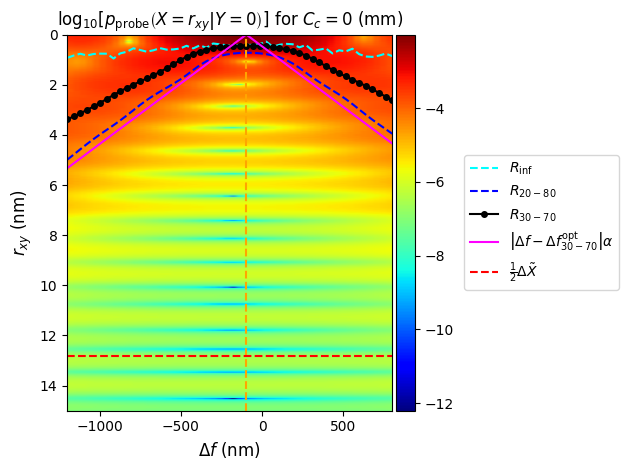

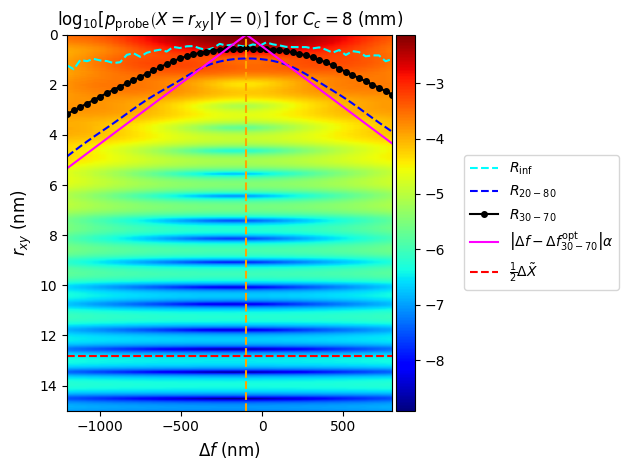

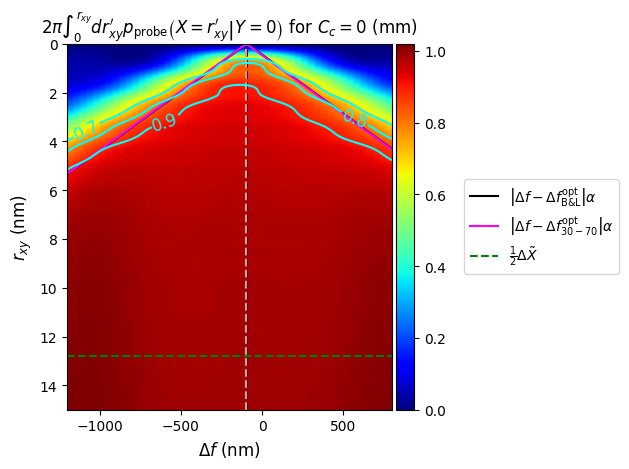

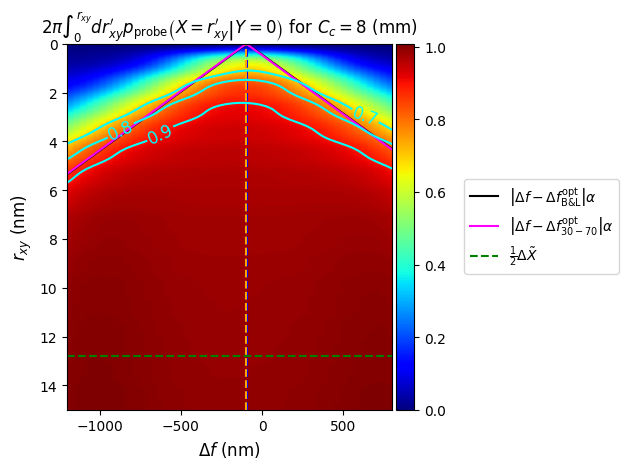

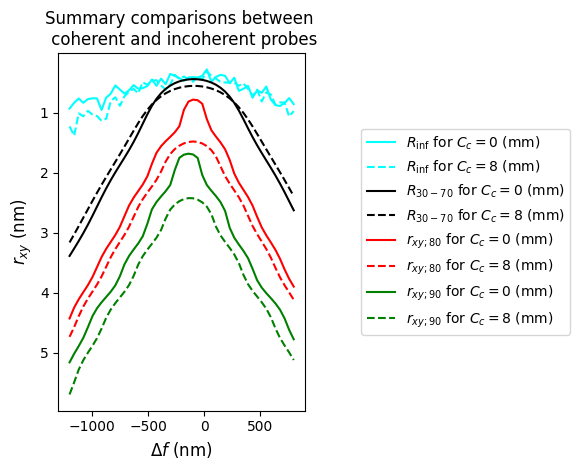

In [12]:
# Used to define axes scales.
end = \
    np.concatenate((np.where(r_xy/10 > max_r_xy_to_plot)[0], [r_xy.size+1]))[0]
extent = \
    [min_target_operating_defocus/10, 
     max_target_operating_defocus/10, 
     r_xy[:end][-1]/10, 
     r_xy[:end][0]/10]



# The following array is used to plot the cone models.
x = np.linspace(min_target_operating_defocus/10, 
                max_target_operating_defocus/10, 
                num=num_target_operating_defocii*10)

title = (r"$\mathrm{log}_{10}\left[p_{\mathrm{probe}}"
         r"\left(\left.X=r_{xy}\right|Y=0\right)\right]$ "
         r"for $C_c=0$ (mm)")

fig_1, ax_1 = plt.subplots()
data = np.log10(intensity_profiles_for_coherent_probes.T[:end, :])
im_1 = ax_1.imshow(data, cmap="jet", extent=extent, aspect="auto")
fig_1.colorbar(im_1, pad=0.01)

ax_1.plot(target_operating_defocii/10, 
          information_resolutions_for_coherent_probes, 
          linewidth=linewidth, 
          color="cyan", 
          linestyle="dashed", 
          label=r"$R_{\mathrm{inf}}$")

ax_1.plot(target_operating_defocii/10, 
          rise_distance_20_80_resolutions_for_coherent_probes, 
          linewidth=linewidth, 
          color="blue", 
          linestyle="dashed", 
          label=r"$R_{\mathrm{20-80}}$")

ax_1.plot(target_operating_defocii/10, 
          rise_distance_30_70_resolutions_for_coherent_probes, 
          linewidth=linewidth, 
          color="black", 
          linestyle="solid",
          marker="o",
          markersize=markersize,
          label=r"$R_{\mathrm{30-70}}$")

label = (r"$\left|\Delta f - "
         r"\Delta f_{\mathrm{30-70}}^{\mathrm{opt}}\right|\alpha$")
ax_1.plot(x, 
          cone_30_70_rise_distance_for_coherent_probes(x), 
          linewidth=linewidth, 
          color="magenta", 
          linestyle="solid", 
          label=label)
ax_1.axvline(optimum_df_30_70_rise_distance_for_coherent_probes, 
             linewidth=linewidth, 
             color="orange", 
             linestyle="dashed")

data = \
    half_width_of_reconstruction_patch*np.ones([num_target_operating_defocii])

ax_1.plot(target_operating_defocii/10, 
          data, 
          linewidth=linewidth, 
          color="red", 
          linestyle="dashed", 
          label=r"$\frac{1}{2} \Delta \tilde{X}$")

ax_1.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
ax_1.set_xlabel(r"$\Delta f$ (nm)", fontsize=fontsize)
ax_1.set_ylabel("$r_{xy}$ (nm)", fontsize=fontsize)
ax_1.set_title(title, fontsize=fontsize)

fig_1.tight_layout()



title = (r"$\mathrm{log}_{10}\left[p_{\mathrm{probe}}"
         r"\left(\left.X=r_{xy}\right|Y=0\right)\right]$ "
         r"for $C_c=8$ (mm)")

fig_2, ax_2 = plt.subplots()
data = np.log10(intensity_profiles_for_incoherent_probes.T[:end, :])
im_2 = ax_2.imshow(data, cmap="jet", extent=extent, aspect="auto")
fig_2.colorbar(im_2, pad=0.01)

ax_2.plot(target_operating_defocii/10, 
          information_resolutions_for_incoherent_probes, 
          linewidth=linewidth, 
          color="cyan", 
          linestyle="dashed", 
          label=r"$R_{\mathrm{inf}}$")

ax_2.plot(target_operating_defocii/10, 
          rise_distance_20_80_resolutions_for_incoherent_probes, 
          linewidth=linewidth, 
          color="blue", 
          linestyle="dashed", 
          label=r"$R_{\mathrm{20-80}}$")

ax_2.plot(target_operating_defocii/10, 
          rise_distance_30_70_resolutions_for_incoherent_probes, 
          linewidth=linewidth, 
          color="black", 
          linestyle="solid",
          marker="o",
          markersize=markersize,
          label=r"$R_{\mathrm{30-70}}$")

label = (r"$\left|\Delta f - "
         r"\Delta f_{\mathrm{30-70}}^{\mathrm{opt}}\right|\alpha$")
ax_2.plot(x, 
          cone_30_70_rise_distance_for_incoherent_probes(x), 
          linewidth=linewidth, 
          color="magenta", 
          linestyle="solid", 
          label=label)
ax_2.axvline(optimum_df_30_70_rise_distance_for_incoherent_probes, 
             linewidth=linewidth, 
             color="orange", 
             linestyle="dashed")

data = \
    half_width_of_reconstruction_patch*np.ones([num_target_operating_defocii])

ax_2.plot(target_operating_defocii/10, 
          data, 
          linewidth=linewidth, 
          color="red", 
          linestyle="dashed", 
          label=r"$\frac{1}{2} \Delta \tilde{X}$")

ax_2.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
ax_2.set_xlabel(r"$\Delta f$ (nm)", fontsize=fontsize)
ax_2.set_ylabel(r"$r_{xy}$ (nm)", fontsize=fontsize)
ax_2.set_title(title, fontsize=fontsize)

fig_2.tight_layout()



title = (r"$2\pi\int_0^{r_{xy}}dr_{xy}^{\prime}"
         r"p_{\mathrm{probe}}\left(\left.X=r_{xy}^{\prime}\right|Y=0\right)$ "
         r"for $C_c=0$ (mm)")

fig_3, ax_3 = plt.subplots()
data = integrated_current_profiles_for_coherent_probes.T[:end, :]
im_3 = ax_3.imshow(data, cmap="jet", extent=extent, aspect="auto")
fig_3.colorbar(im_3, pad=0.01)

label = (r"$\left|\Delta f - "
         r"\Delta f_{\mathrm{B&L}}^{\mathrm{opt}}\right|\alpha$")
ax_3.plot(x, 
          cone_black_and_linfoot(x), 
          linewidth=linewidth, 
          color="black", 
          linestyle="solid", 
          label=label)
ax_3.axvline(optimum_df_black_and_linfoot, 
             linewidth=linewidth, 
             color="blue", 
             linestyle="dashed")
          
label = (r"$\left|\Delta f - "
         r"\Delta f_{\mathrm{30-70}}^{\mathrm{opt}}\right|\alpha$")
ax_3.plot(x, 
          cone_30_70_rise_distance_for_coherent_probes(x), 
          linewidth=linewidth, 
          color="magenta", 
          linestyle="solid", 
          label=label)
ax_3.axvline(optimum_df_30_70_rise_distance_for_coherent_probes, 
             linewidth=linewidth, 
             color="orange", 
             linestyle="dashed")

data = \
    half_width_of_reconstruction_patch*np.ones([num_target_operating_defocii])

ax_3.plot(target_operating_defocii/10, 
          data, 
          linewidth=linewidth, 
          color="green", 
          linestyle="dashed", 
          label=r"$\frac{1}{2} \Delta \tilde{X}$")

ax_3.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
ax_3.set_xlabel(r"$\Delta f$ (nm)", fontsize=fontsize)
ax_3.set_ylabel(r"$r_{xy}$ (nm)", fontsize=fontsize)
ax_3.set_title(title, fontsize=fontsize)

cs = ax_3.contour(target_operating_defocii/10, 
                  r_xy[:end]/10, 
                  integrated_current_profiles_for_coherent_probes.T[:end, :], 
                  levels=[0.7, 0.8, 0.9], 
                  linewidths=linewidth,
                  colors="cyan", 
                  linestyles="solid")
ax_3.clabel(cs, inline=True, fontsize=fontsize)

fig_3.tight_layout()



title = (r"$2\pi\int_0^{r_{xy}}dr_{xy}^{\prime}"
         r"p_{\mathrm{probe}}\left(\left.X=r_{xy}^{\prime}\right|Y=0\right)$ "
         r"for $C_c=8$ (mm)")

fig_4, ax_4 = plt.subplots()
data = integrated_current_profiles_for_incoherent_probes.T[:end, :]
im_4 = ax_4.imshow(data, cmap="jet", extent=extent, aspect="auto")
fig_4.colorbar(im_4, pad=0.01)

label = (r"$\left|\Delta f - "
         r"\Delta f_{\mathrm{B&L}}^{\mathrm{opt}}\right|\alpha$")
ax_4.plot(x, 
          cone_black_and_linfoot(x), 
          linewidth=linewidth, 
          color="black", 
          linestyle="solid", 
          label=label)
ax_4.axvline(optimum_df_black_and_linfoot, 
             linewidth=linewidth, 
             color="blue", 
             linestyle="dashed")
          
label = (r"$\left|\Delta f - "
         r"\Delta f_{\mathrm{30-70}}^{\mathrm{opt}}\right|\alpha$")
ax_4.plot(x, 
          cone_30_70_rise_distance_for_incoherent_probes(x), 
          linewidth=linewidth, 
          color="magenta", 
          linestyle="solid", 
          label=label)
ax_4.axvline(optimum_df_30_70_rise_distance_for_incoherent_probes, 
             linewidth=linewidth, 
             color="orange", 
             linestyle="dashed")

data = \
    half_width_of_reconstruction_patch*np.ones([num_target_operating_defocii])

ax_4.plot(target_operating_defocii/10, 
          data, 
          linewidth=linewidth, 
          color="green", 
          linestyle="dashed", 
          label=r"$\frac{1}{2} \Delta \tilde{X}$")

ax_4.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
ax_4.set_xlabel(r"$\Delta f$ (nm)", fontsize=fontsize)
ax_4.set_ylabel(r"$r_{xy}$ (nm)", fontsize=fontsize)
ax_4.set_title(title, fontsize=fontsize)

cs = ax_4.contour(target_operating_defocii/10, 
                  r_xy[:end]/10, 
                  integrated_current_profiles_for_incoherent_probes.T[:end, :], 
                  levels=[0.7, 0.8, 0.9], 
                  linewidths=linewidth,
                  colors="cyan", 
                  linestyles="solid")
ax_4.clabel(cs, inline=True, fontsize=fontsize)

fig_4.tight_layout()



title = ("Summary comparisons between \n coherent and incoherent probes")

fig_5, ax_5 = plt.subplots()
          
ax_5.plot(target_operating_defocii/10, 
          information_resolutions_for_coherent_probes, 
          linewidth=linewidth, 
          color="cyan", 
          linestyle="solid", 
          label=r"$R_{\mathrm{inf}}$ for $C_c=0$ (mm)")

ax_5.plot(target_operating_defocii/10, 
          information_resolutions_for_incoherent_probes, 
          linewidth=linewidth, 
          color="cyan", 
          linestyle="dashed", 
          label=r"$R_{\mathrm{inf}}$ for $C_c=8$ (mm)")

ax_5.plot(target_operating_defocii/10, 
          rise_distance_30_70_resolutions_for_coherent_probes, 
          linewidth=linewidth, 
          color="black", 
          linestyle="solid",
          label=r"$R_{\mathrm{30-70}}$ for $C_c=0$ (mm)")

ax_5.plot(target_operating_defocii/10, 
          rise_distance_30_70_resolutions_for_incoherent_probes, 
          linewidth=linewidth, 
          color="black", 
          linestyle="dashed",
          label=r"$R_{\mathrm{30-70}}$ for $C_c=8$ (mm)")

ax_5.plot(target_operating_defocii/10, 
          integrated_current_80_percent_contour_for_coherent_probes, 
          linewidth=linewidth, 
          color="red", 
          linestyle="solid", 
          label=r"$r_{xy;80}$ for $C_c=0$ (mm)")
ax_5.plot(target_operating_defocii/10, 
          integrated_current_80_percent_contour_for_incoherent_probes, 
          linewidth=linewidth, 
          color="red", 
          linestyle="dashed", 
          label=r"$r_{xy;80}$ for $C_c=8$ (mm)")

ax_5.plot(target_operating_defocii/10, 
          integrated_current_90_percent_contour_for_coherent_probes, 
          linewidth=linewidth, 
          color="green", 
          linestyle="solid", 
          label=r"$r_{xy;90}$ for $C_c=0$ (mm)")
ax_5.plot(target_operating_defocii/10, 
          integrated_current_90_percent_contour_for_incoherent_probes, 
          linewidth=linewidth, 
          color="green", 
          linestyle="dashed", 
          label=r"$r_{xy;90}$ for $C_c=8$ (mm)")

ax_5.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
ax_5.set_ylim(ax_5.get_ylim()[::-1])
ax_5.set_xlabel(r"$\Delta f$ (nm)", fontsize=fontsize)
ax_5.set_ylabel(r"$r_{xy}$ (nm)", fontsize=fontsize)
ax_5.set_title(title, fontsize=fontsize)

fig_5.tight_layout()



_ = plt.plot()